# This Notebook will be Utilized for CapStone Project

## IBM Data Science Course 9

# Week 1

Creating the Repository

# Week 2

### Introduction/Business Problem:

The aim of the project is to create a model which will be able to predict the 
Possibility and Severity of an accident depending upon Weather Conditions, 
Road Conditions and other relevant attributes so that you can drive more carefully.

### Data Description

The dataset being used is the one which is available in the capstone project. No external dataset has been used.

Dataset contains records of all types of collisions recorded in Traffic records and shared by SDOT Traffic Management Division. Timeframe : 2004 to Present

We will be performing extensive Exploratory Data Analysis and understand the variables distribution. Many of the attributes available are post facto and are for record keeping, which will be removed.

We will be selecting the variables having information pertaining to cause of accidents and severity.

There are a total of 194673 rows and 38 columns in the data.

Target Variable : SEVERITYCODE

# Week 3

### Importing Libraries and Creating Useful Fucntions

In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [ ]:
#get iqr
def iqr(x):
    return x.quantile(q=0.75)-x.quantile(q=0.25)

#get outliars x>75% quantile+1.5*IQR + x<25% quantile-1.5*IQR
def outlier_cnt(x):
    upper_cnt = x.quantile(q=0.75)+ 1.5*iqr(x)
    lower_cnt = x.quantile(q=0.25)- 1.5*iqr(x)
    return len(x[x>upper_cnt]) + len(x[x<lower_cnt])

def remove_outlier(x):
    upper_cnt = x.quantile(q=0.75) + 1.5*iqr
    lower_cnt = x.quantile(q=0.25) - 1.5*iqr
    return x[(x<=upper_cnt) & (x>=lower_cnt)]

In [ ]:
#function to get dataframe information
def data_information(x,todrop):
    x1 = x.drop(todrop, axis=1)
    
    dict={}
    dict['Number of Observation']= len(x1)
    dict['Number of Variables']= len(x1.columns)
    dict['Number of Numeric Variables']= len(x1.select_dtypes(include='number').columns)
    dict['Number of Factor Variables']= len(x1.select_dtypes(include='category').columns)
    dict['Number of Categorical Variables']= len(x1.select_dtypes(include='object').columns)
    dict['Number of Date Variables']= len(x1.select_dtypes(include='datetime64').columns)
    dict['Number of Logical Variables']= len(x1.select_dtypes(include='bool').columns)
    #dict['Number of Zero Variance Variables']= 
    null_pct = pd.DataFrame(x1.isnull().sum()/x1.shape[0])
    null_pct.columns = ['null_pct']
    
    dict['Num of Variables having complete cases']= null_pct[null_pct.null_pct==0].shape[0]
    dict['Num of Variables with <=50Pct missing cases']= null_pct[null_pct.null_pct<=0.5].shape[0]
    dict['Num of Variables with >50Pct missing cases']= null_pct[null_pct.null_pct>0.5].shape[0]
    dict['Num of Variables with >90Pct missing cases']= null_pct[null_pct.null_pct>0.9].shape[0]

    dict['Pct of Variables having complete cases']= null_pct[null_pct.null_pct==0].shape[0]*100/x1.shape[1]
    dict['Pct of Variables with <=50Pct missing cases']= null_pct[null_pct.null_pct<=0.5].shape[0]*100/x1.shape[1]
    dict['Pct of Variables with >50Pct missing cases']= null_pct[null_pct.null_pct>0.5].shape[0]*100/x1.shape[1]
    dict['Pct of Variables with >90Pct missing cases']= null_pct[null_pct.null_pct>0.9].shape[0]*100/x1.shape[1]
    
    data_info = pd.DataFrame(dict, index=['Values'])
    return data_info.T.round(2)

In [ ]:
#function for numerical analysis

def num_univariate(x,todrop):
    x1 = x.drop(todrop, axis=1)
    
    x1 = x1.select_dtypes(include='number')
    data_num_info = pd.DataFrame()
    
    for i in x1.columns:
        data_num_info.loc[i,'Negative Value Count']=x1[x1[i]<0].shape[0]
        data_num_info.loc[i,'Positive Value Count']=x1[x1[i]>0].shape[0]
        data_num_info.loc[i,'Zeros Count']=x1[x1[i]==0].shape[0]
        data_num_info.loc[i,'Unique Count']=x1[i].unique().shape[0]
        data_num_info.loc[i,'Missing Percent']=x1[i].isnull().sum()*100/x1.shape[0]
        data_num_info.loc[i,'Count of Outliers']=outlier_cnt(x1[i])
    return data_num_info.round(2)

In [ ]:
#function for categorical analysis

def cat_univariate(x,todrop):
    x1 = x.drop(columns=todrop)
    
    x1 = x1.select_dtypes(include=['object','bool','category'])
    data_cat_info = pd.DataFrame()
    try: #incase any categorical variable is not present
        for i in x1.columns:
            data_cat_info.loc[i,'Unique Categories'] = x1[i].unique().shape[0]
            data_cat_info.loc[i,'Missing Percent'] = x1[i].isnull().sum()*100/x1.shape[0]
    except:
        pass
    return data_cat_info.round(2)

In [ ]:
#function for Statistical analysis

def stats_data(x,todrop):
    x1 = x.drop(todrop, axis=1)
    
    x1 = x1.select_dtypes(include='number')
    data_stat_info = pd.DataFrame()
    data_stat_info = x1.describe().T
    
    for i in x1.columns:
        data_stat_info.loc[i,'10%'] = x1[i].quantile(q=0.1)
        data_stat_info.loc[i,'90%'] = x1[i].quantile(q=0.9)
        data_stat_info.loc[i,'99%'] = x1[i].quantile(q=0.99)
        data_stat_info.loc[i,'outlier_count'] = outlier_cnt(x1[i])
        
    
    return data_stat_info.round(2)

In [ ]:
#function for numerical data exploration

def num_check(x, todrop, group):
    x1 = x.drop(columns=todrop)
    
    x1 = x1.select_dtypes(include='number')
    
    for g in group:
        summary = pd.DataFrame()
        for i in x1.columns:
            sub_summary = x1.groupby(g)[i].describe().reset_index()
            sub_summary['Variable'] = i
            summary = sub_summary.append(summary)
        summary = summary.set_index(['Variable',g])
    return summary.round(2)

In [ ]:
#create classes to data visualization

class plotting(object):
    def __init__(self,x):
        self.x = x
        
    def num_plt(self):
        bins = max(round(self.x.nunique()/100),min(round(self.x.nunique()),10))
        plt1 = sns.distplot(self.x,hist=True,kde=True,bins=bins,color='C4',rug=False)
        plt.xticks(rotation=45)
        
    def wo_outlier_num_plt(self):
        self.x= remove_outlier(self.x)
        bins = max(round(self.x.nunique()/100),min(round(self.x.nunique()),10))
        plt2 = sns.distplot(self.x,hist=True,kde=True,bins=bins,color='C2',rug=False)
        plt.xticks(rotation=45)
        
    def cat_plt(self):
        plt.hist(self.x)
        plt.xticks(rotation=90)
        
    def distrib_plt(self):
        if self.x.dtypes == 'bool' or self.x.dtypes=='object':
            self.cat_plt()
        else:
            self.num_plt()
    
    def wo_outlier_distrib_plt(self):
        if self.x.dtypes == 'bool' or self.x.dtypes=='object':
            self.cat_plt()
        else:
            self.wo_outlier_num_plt()
            
class plotted(object):
    def __init__(self,x, todrop):
        self.x=x
        self.todrop=todrop
        
    def density_plt(self):
        d = self.x.drop(columns=self.todrop)
        
        for i in d.columns:
            plotting(d[d[i].notnull()][i]).distrib_plt()
            plt.xlabel(i)
            plt.ylabel('Count')
            plt.show()
            
    def wo_outlier_density_plt(self):
        d = self.x.drop(columns=self.todrop)
        
        for i in d.columns:
            plotting(d[d[i].notnull()][i]).wo_outlier_distrib_plt()
            plt.xlabel(i)
            plt.ylabel('Count')
            plt.show()
            
    def box_plt(self):
        d = self.x.drop(columns=self.todrop)
        d = self.x.select_dtypes(include='number')
        
        for i in d.columns:
            sns.boxplot(d[d[i].notnull()][i],orient='v')
            plt.xlabel(i)
            plt.ylabel('Value')
            plt.show()
            
    def wo_outlier_box_plt(self):
        d = self.x.drop(columns=self.todrop)
        d = self.x.select_dtypes(include='number')
        
        for i in d.columns:
            sns.boxplot(remove_outlier(d[d[i].notnull()][i]),orient='v')
            plt.xlabel(i)
            plt.ylabel('Value')
            plt.show()

###Get the data

In [4]:
#Unizipping the data from google drive 
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Data-Collisions.csv.zip", 'r')
zip_ref.extractall("/content/drive/My Drive/Unzippeddata")
zip_ref.close()

#data_path = r"/Users/rahulsharma/Downloads/Data-Collisions.csv";
#df = pd.read_csv(data_path)
#df.tail()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [5]:
#reading the data from drive
df = pd.read_csv(r"/content/drive/My Drive/Unzippeddata/Data-Collisions.csv", low_memory=False)
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,5TH AVE NE AND NE 103RD ST,,NaN,2,Injury Collision,Angles,2,0,0,2,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Overcast,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),16,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,0,Raining,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,NaN,NaN,1,Property Damage Only Collision,Parked Car,4,0,0,3,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Overcast,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,2ND AVE BETWEEN MARION ST AND MADISON ST,,NaN,1,Property Damage Only Collision,Other,3,0,0,3,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,SWIFT AVE S AND SWIFT AV OFF RP,NaN,NaN,2,Injury Collision,Angles,2,0,0,2,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Raining,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [ ]:
df.shape

(194673, 38)

In [ ]:
#getting column list
df.columns.tolist()

['SEVERITYCODE',
 'X',
 'Y',
 'OBJECTID',
 'INCKEY',
 'COLDETKEY',
 'REPORTNO',
 'STATUS',
 'ADDRTYPE',
 'INTKEY',
 'LOCATION',
 'EXCEPTRSNCODE',
 'EXCEPTRSNDESC',
 'SEVERITYCODE.1',
 'SEVERITYDESC',
 'COLLISIONTYPE',
 'PERSONCOUNT',
 'PEDCOUNT',
 'PEDCYLCOUNT',
 'VEHCOUNT',
 'INCDATE',
 'INCDTTM',
 'JUNCTIONTYPE',
 'SDOT_COLCODE',
 'SDOT_COLDESC',
 'INATTENTIONIND',
 'UNDERINFL',
 'WEATHER',
 'ROADCOND',
 'LIGHTCOND',
 'PEDROWNOTGRNT',
 'SDOTCOLNUM',
 'SPEEDING',
 'ST_COLCODE',
 'ST_COLDESC',
 'SEGLANEKEY',
 'CROSSWALKKEY',
 'HITPARKEDCAR']

### Understanding Target Variable

In [ ]:
df['SEVERITYCODE'].describe()

count    194673.000000
mean          1.298901
std           0.457778
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           2.000000
Name: SEVERITYCODE, dtype: float64

In [ ]:
df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

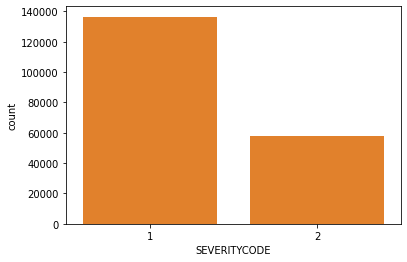

In [ ]:
sns.countplot(df['SEVERITYCODE'], color='C1')

### Analyzing Attributes : Univariate Analysis

In [ ]:
data_information(df,['SEVERITYCODE'])

,Values
Number of Observation,194673.00
Number of Variables,37.00
Number of Numeric Variables,15.00
Number of Factor Variables,0.00
Number of Categorical Variables,22.00
Number of Date Variables,0.00
Number of Logical Variables,0.00
Num of Variables having complete cases,18.00
Num of Variables with <=50Pct missing cases,31.00
Num of Variables with >50Pct missing cases,6.00


In [ ]:
num_univariate(df,['SEVERITYCODE'])

,Negative Value Count,Positive Value Count,Zeros Count,Unique Count,Missing Percent,Count of Outliers
X,189339.0,0.0,0.0,23564.0,2.74,1560.0
Y,0.0,189339.0,0.0,23840.0,2.74,0.0
OBJECTID,0.0,194673.0,0.0,194673.0,0.00,0.0
INCKEY,0.0,194673.0,0.0,194673.0,0.00,0.0
COLDETKEY,0.0,194673.0,0.0,194673.0,0.00,0.0
INTKEY,0.0,65070.0,0.0,7615.0,66.57,1404.0
SEVERITYCODE.1,0.0,194673.0,0.0,2.0,0.00,0.0
PERSONCOUNT,0.0,189129.0,5544.0,47.0,0.00,17075.0
PEDCOUNT,0.0,6939.0,187734.0,7.0,0.00,6939.0
PEDCYLCOUNT,0.0,5484.0,189189.0,3.0,0.00,5484.0


In [ ]:
cat_univariate(df,['SEVERITYCODE'])

,Unique Categories,Missing Percent
REPORTNO,194670.0,0.00
STATUS,2.0,0.00
ADDRTYPE,4.0,0.99
LOCATION,24103.0,1.38
EXCEPTRSNCODE,3.0,56.43
EXCEPTRSNDESC,2.0,97.10
SEVERITYDESC,2.0,0.00
COLLISIONTYPE,11.0,2.52
INCDATE,5985.0,0.00
INCDTTM,162058.0,0.00


In [ ]:
stats_data(df,['SEVERITYCODE'])

,count,mean,std,min,25%,50%,75%,max,10%,90%,99%,outlier_count
X,189339.0,-122.33,0.03,-122.42,-122.35,-122.33,-122.31,-122.24,-122.37,-122.29,-122.27,1560.0
Y,189339.0,47.62,0.06,47.50,47.58,47.62,47.66,47.73,47.54,47.70,47.73,0.0
OBJECTID,194673.0,108479.36,62649.72,1.00,54267.00,106912.00,162272.00,219547.00,23695.40,196557.80,217258.28,0.0
INCKEY,194673.0,141091.46,86634.40,1001.00,70383.00,123363.00,203319.00,331454.00,39749.20,282298.80,328483.28,0.0
COLDETKEY,194673.0,141298.81,86986.54,1001.00,70383.00,123363.00,203459.00,332954.00,39749.20,283158.80,329983.28,0.0
INTKEY,65070.0,37558.45,51745.99,23807.00,28667.00,29973.00,33973.00,757580.00,25483.80,36525.00,351236.61,1404.0
SEVERITYCODE.1,194673.0,1.30,0.46,1.00,1.00,1.00,2.00,2.00,1.00,2.00,2.00,0.0
PERSONCOUNT,194673.0,2.44,1.35,0.00,2.00,2.00,3.00,81.00,2.00,4.00,7.00,17075.0
PEDCOUNT,194673.0,0.04,0.20,0.00,0.00,0.00,0.00,6.00,0.00,0.00,1.00,6939.0
PEDCYLCOUNT,194673.0,0.03,0.17,0.00,0.00,0.00,0.00,2.00,0.00,0.00,1.00,5484.0


In [ ]:
num_check(df,['OBJECTID'],['SEVERITYCODE'])

count        mean  ...          75%          max
Variable       SEVERITYCODE                        ...                          
CROSSWALKKEY   1             136485.0     1520.24  ...         0.00    638921.00
               2              58188.0    29162.20  ...         0.00   5239700.00
SEGLANEKEY     1             136485.0       43.64  ...         0.00     45540.00
               2              58188.0      798.93  ...         0.00    525241.00
SDOTCOLNUM     1              81429.0  7965599.04  ...  10143012.00  13072024.00
               2              33507.0  7989343.96  ...  10180019.00  13072022.00
SDOT_COLCODE   1             136485.0       13.02  ...        14.00        69.00
               2              58188.0       15.85  ...        16.00        69.00
VEHCOUNT       1             136485.0        1.94  ...         2.00        12.00
               2              58188.0        1.87  ...         2.00        11.00
PEDCYLCOUNT    1             136485.0        0.00  ...         0.00         1.00
               2              58188.0        0.08  ...         0.00         2.00
PEDCOUNT       1             136485.0        0.01  ...         0.00         3.00
               2              58188.0        0.11  ...         0.00         6.00
PERSONCOUNT    1             136485.0        2.33  ...         3.00        57.00
               2              58188.0        2.71  ...         3.00        81.00
SEVERITYCODE.1 1             136485.0        1.00  ...         1.00         1.00
               2              58188.0        2.00  ...         2.00         2.00
INTKEY         1              37251.0    37265.44  ...     33645.00    757580.00
               2              27819.0    37950.81  ...     34147.00    725404.00
COLDETKEY      1             136485.0   140044.81  ...    200814.00    332954.00
               2              58188.0   144240.17  ...    208855.25    332953.00
INCKEY         1             136485.0   139843.29  ...    200674.00    331454.00
               2              58188.0   144019.15  ...    208655.25    331453.00
Y              1             132221.0       47.62  ...        47.66        47.73
               2              57118.0       47.62  ...        47.67        47.73
X              1             132221.0     -122.33  ...      -122.31      -122.24
               2              57118.0     -122.33  ...      -122.31      -122.24
SEVERITYCODE   1             136485.0        1.00  ...         1.00         1.00
               2              58188.0        2.00  ...         2.00         2.00

[30 rows x 8 columns]

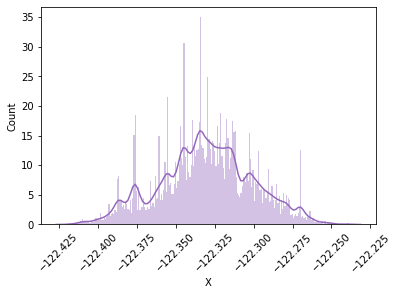

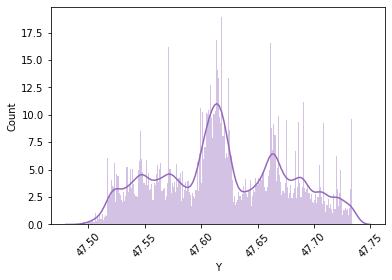

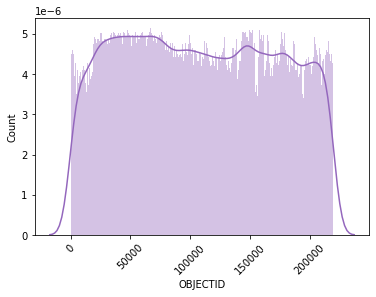

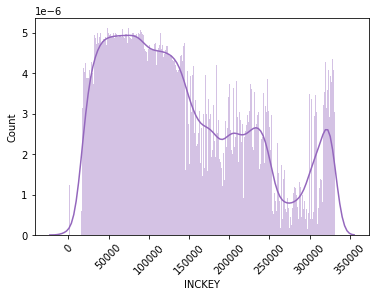

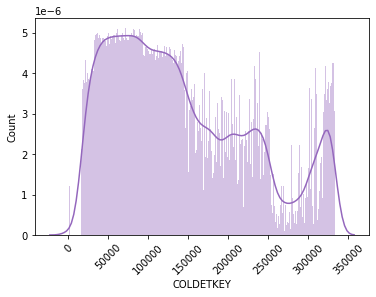

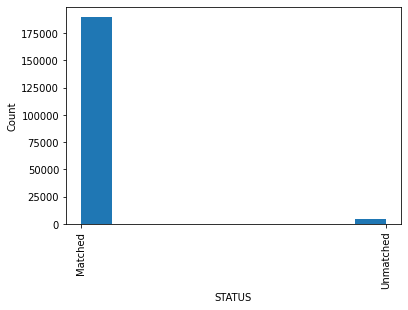

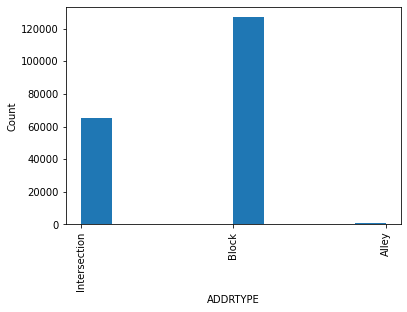

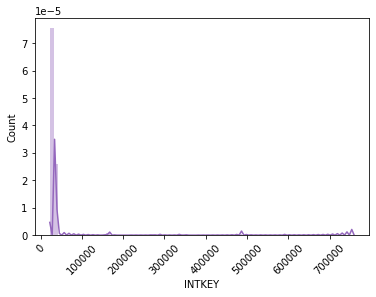

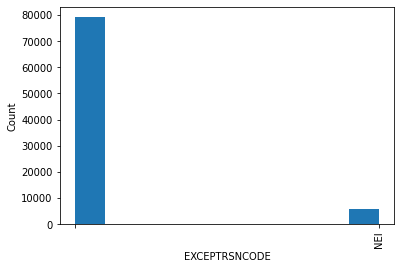

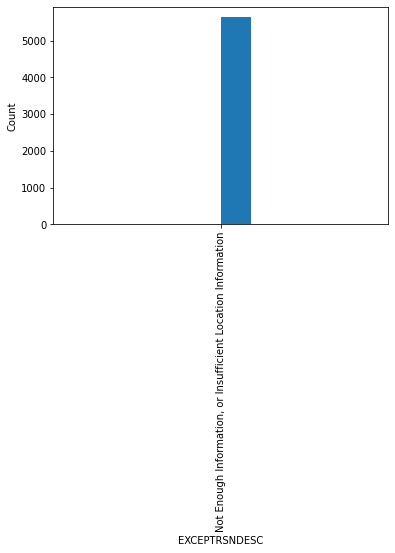

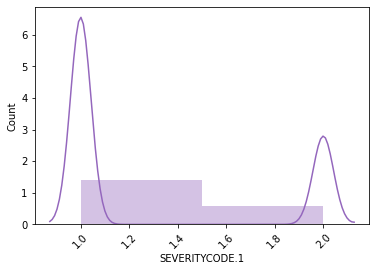

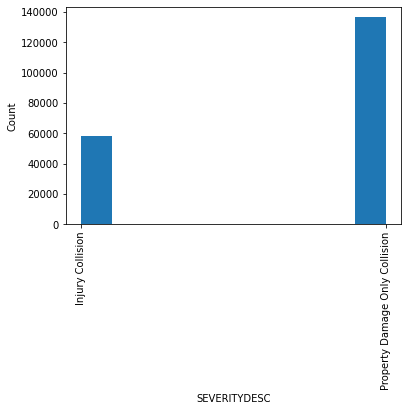

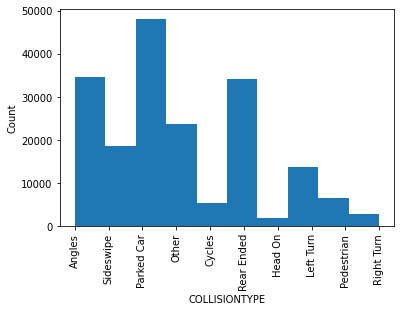

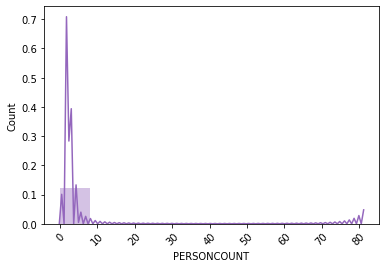

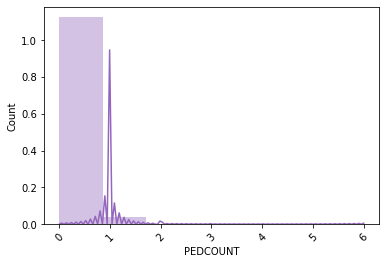

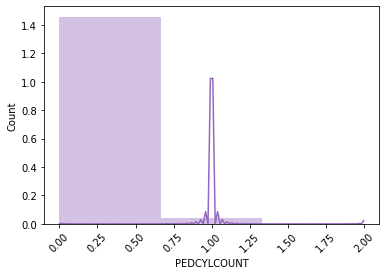

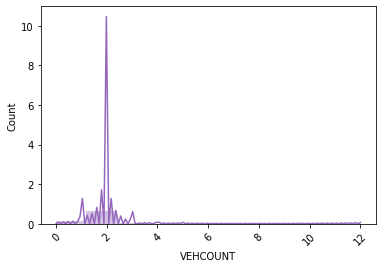

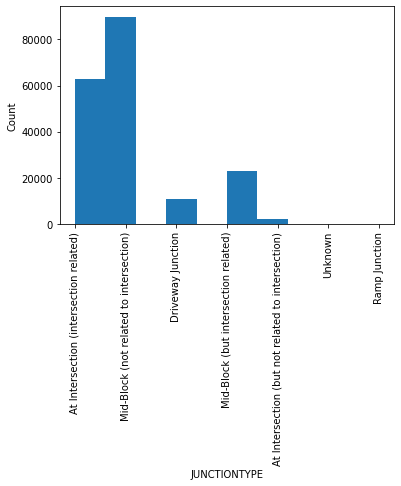

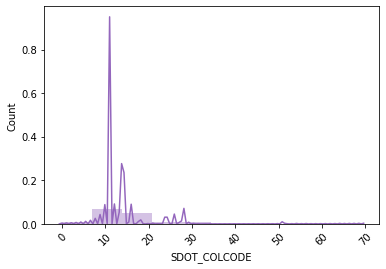

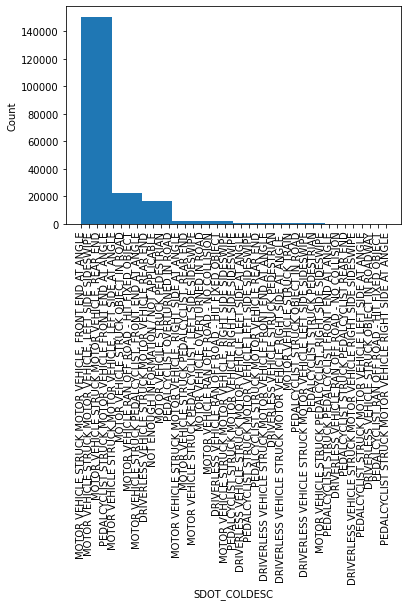

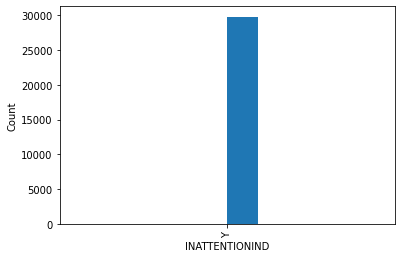

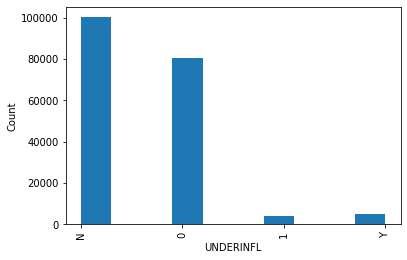

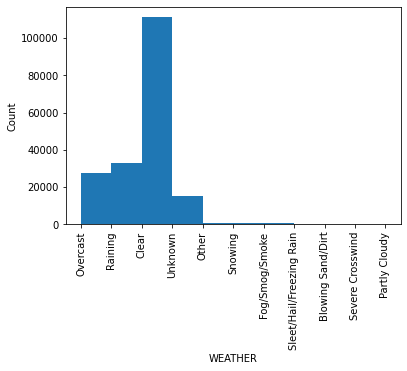

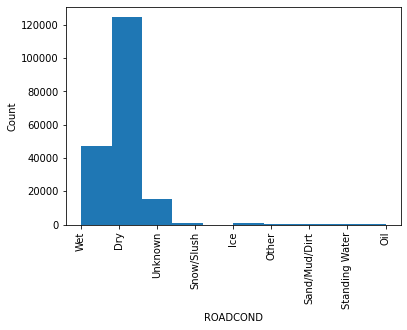

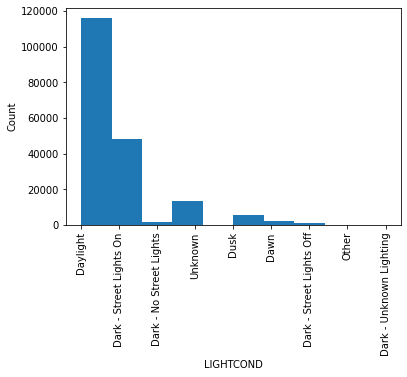

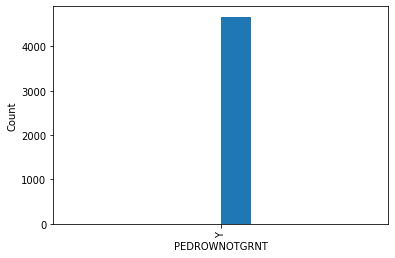

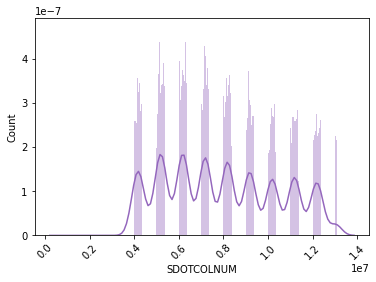

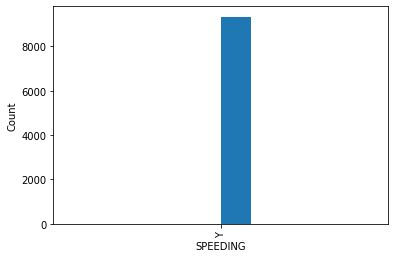

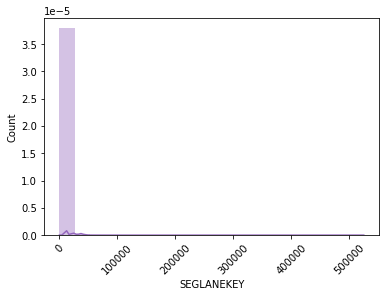

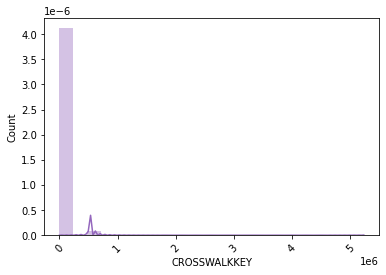

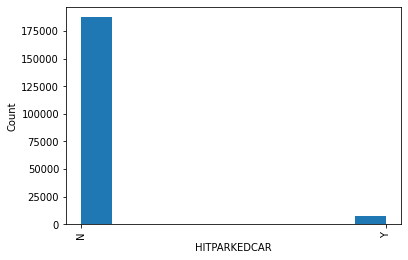

In [ ]:
plotted(df,['SEVERITYCODE','REPORTNO','INCDATE','INCDTTM','LOCATION','ST_COLCODE','ST_COLDESC']).density_plt()

In [ ]:
#for i in colnames:
#    print('Data Type of :', i ,'is ',df[i].dtype,' and Unique values are :',len(df[i].unique()),' and null values are :',df[i].isnull().sum())

In [ ]:
#Categorical Variables with only 1 value
for i in df.columns:
  if df[df[i].notnull()][i].nunique()==1:
    print(i,df[df[i].notnull()][i].unique())

EXCEPTRSNDESC ['Not Enough Information, or Insufficient Location Information']
INATTENTIONIND ['Y']
PEDROWNOTGRNT ['Y']
SPEEDING ['Y']


In [ ]:
df.groupby('SEVERITYCODE')['SPEEDING'].describe()

,count,unique,top,freq
SEVERITYCODE,,,,
1,5802,1,Y,5802
2,3531,1,Y,3531


In [ ]:
df.describe()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,INTKEY,SEVERITYCODE.1,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,SDOT_COLCODE,SDOTCOLNUM,SEGLANEKEY,CROSSWALKKEY
count,194673.000000,189339.000000,189339.000000,194673.000000,194673.000000,194673.000000,65070.000000,194673.000000,194673.000000,194673.000000,194673.000000,194673.000000,194673.000000,1.149360e+05,194673.000000,1.946730e+05
mean,1.298901,-122.330518,47.619543,108479.364930,141091.456350,141298.811381,37558.450576,1.298901,2.444427,0.037139,0.028391,1.920780,13.867768,7.972521e+06,269.401114,9.782452e+03
std,0.457778,0.029976,0.056157,62649.722558,86634.402737,86986.542110,51745.990273,0.457778,1.345929,0.198150,0.167413,0.631047,6.868755,2.553533e+06,3315.776055,7.226926e+04
min,1.000000,-122.419091,47.495573,1.000000,1001.000000,1001.000000,23807.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.007024e+06,0.000000,0.000000e+00
25%,1.000000,-122.348673,47.575956,54267.000000,70383.000000,70383.000000,28667.000000,1.000000,2.000000,0.000000,0.000000,2.000000,11.000000,6.040015e+06,0.000000,0.000000e+00
50%,1.000000,-122.330224,47.615369,106912.000000,123363.000000,123363.000000,29973.000000,1.000000,2.000000,0.000000,0.000000,2.000000,13.000000,8.023022e+06,0.000000,0.000000e+00
75%,2.000000,-122.311937,47.663664,162272.000000,203319.000000,203459.000000,33973.000000,2.000000,3.000000,0.000000,0.000000,2.000000,14.000000,1.015501e+07,0.000000,0.000000e+00
max,2.000000,-122.238949,47.734142,219547.000000,331454.000000,332954.000000,757580.000000,2.000000,81.000000,6.000000,2.000000,12.000000,69.000000,1.307202e+07,525241.000000,5.239700e+06


#### INTKEY

In [ ]:
#missing value percentage 
df['INTKEY'].isnull().sum()*100/df.shape[0]
#close to 67% missing, will drop this variable

66.57471760336564

#### SDOTCOLNUM

In [ ]:
#missing value percentage
df['SDOTCOLNUM'].isnull().sum()*100/df.shape[0]

40.95945508622151

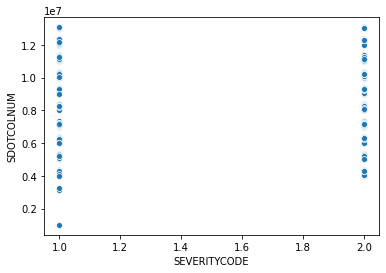

In [ ]:
sns.scatterplot(df['SEVERITYCODE'],df['SDOTCOLNUM'])

In [ ]:
df['SDOTCOLNUM'].nunique()

114932

In [ ]:
#An ID given to the collision by SDOT, will be dropped

#### STATUS

In [ ]:
df['STATUS'].value_counts()[0]/df.shape[0]
#97%+ values are in the same value. Dropping the variable   

0.9748963646730672

###BiVariate Analysis

In [ ]:
#Crosstab Categorical Variables with Target Variable
def cat_bivariate_crosstabs(x,todrop):
  df_cat = x.drop(columns=todrop)
  df_cat = df_cat.select_dtypes(include=['object','bool'])
  print(df_cat.columns)
  for col in df_cat.columns:
    print(pd.crosstab(x['SEVERITYCODE'],x[col]))

In [ ]:
cat_bivariate_crosstabs(df,['SEVERITYCODE'])  

Index(['REPORTNO', 'STATUS', 'ADDRTYPE', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYDESC', 'COLLISIONTYPE', 'INCDATE', 'INCDTTM',
       'JUNCTIONTYPE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL',
       'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SPEEDING',
       'ST_COLCODE', 'ST_COLDESC', 'HITPARKEDCAR'],
      dtype='object')
REPORTNO      1007488  1007489  1007491  ...  e392544  e463420  e943304
SEVERITYCODE                             ...                           
1                   0        1        1  ...        1        1        1
2                   1        0        0  ...        0        0        0

[2 rows x 194670 columns]
STATUS        Matched  Unmatched
SEVERITYCODE                    
1              132627       3858
2               57159       1029
ADDRTYPE      Alley  Block  Intersection
SEVERITYCODE                            
1               669  96830         37251
2                82  30096         27819
LOCATION      10TH AVE A

#### ST_COLCODE and ST_COLDESC Relationship check

In [ ]:
temp1=pd.DataFrame(df.groupby('ST_COLCODE')['ST_COLDESC'].unique())
print(temp1)
#Can drop ST_COLDESC

                                                   ST_COLDESC
ST_COLCODE                                                   
                                                        [nan]
0                    [Vehicle going straight hits pedestrian]
1                     [Vehicle turning right hits pedestrian]
10                                        [Entering at angle]
11          [From same direction - both going straight - b...
...                                                       ...
83          [Same direction -- both turning left -- both m...
84          [Same direction -- both turning left -- one st...
85                                     [Vehicle Strikes Deer]
87            [Vehicle Strikes All Other Non-Domestic Animal]
88                                  [All Other Multi Vehicle]

[63 rows x 1 columns]


#### SDOT_COLCODE and SDOT_COLDESC Relationship check

In [ ]:
df.groupby('SDOT_COLCODE')['SDOT_COLDESC'].unique()
#No Missing values. can drop SDOT_COLDESC

SDOT_COLCODE
0             [NOT ENOUGH INFORMATION / NOT APPLICABLE]
11    [MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END...
12    [MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SID...
13    [MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE...
14       [MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END]
15    [MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SID...
16    [MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE...
18    [MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END ...
21        [MOTOR VEHICLE STRUCK PEDALCYCLIST, REAR END]
22    [MOTOR VEHICLE STRUCK PEDALCYCLIST, RIGHT SIDE...
23    [MOTOR VEHICLE STRUCK PEDALCYCLIST, LEFT SIDE ...
24                    [MOTOR VEHCILE STRUCK PEDESTRIAN]
25                         [MOTOR VEHICLE STRUCK TRAIN]
26                [MOTOR VEHICLE STRUCK OBJECT IN ROAD]
27          [MOTOR VEHICLE RAN OFF ROAD - NO COLLISION]
28      [MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT]
29                   [MOTOR VEHICLE OVERTURNED IN ROAD]
31    [DRIVERLESS VEHICLE STRUCK MO

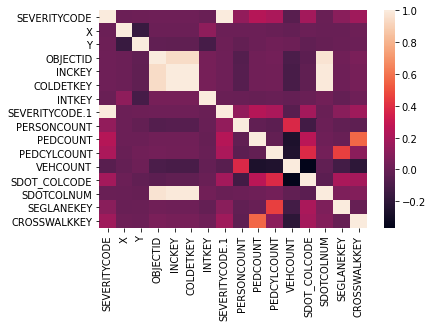

In [ ]:
sns.heatmap(df.corr())

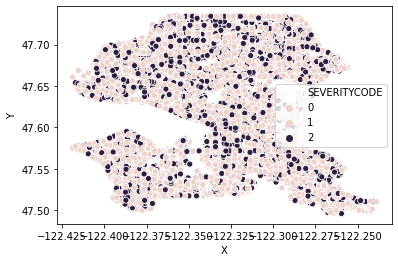

In [ ]:
sns.scatterplot(df['X'],df['Y'], hue=df['SEVERITYCODE'])

#### PEDCOUNT

In [ ]:
pd.crosstab(df['SEVERITYCODE'],df['PEDCOUNT'])

PEDCOUNT,0,1,2,3,4,5,6
SEVERITYCODE,,,,,,,
1,135787,678,19,1,0,0,0
2,51947,6007,207,21,4,1,1


In [ ]:
df['PEDCOUNT'].isnull().sum() 

0

#### PERSONCOUNT

In [ ]:
pd.crosstab(df['SEVERITYCODE'],df['PERSONCOUNT'])

PERSONCOUNT,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,39,41,43,44,47,48,53,54,57,81
SEVERITYCODE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3782,9858,86420,22092,8365,3615,1345,494,249,87,54,23,13,9,12,4,3,3,5,3,5,2,2,1,1,5,4,2,2,2,1,1,2,1,1,2,2,0,1,1,6,3,0,1,0,1,0
2,1762,3296,27811,13461,6295,2969,1357,637,284,129,74,33,20,12,7,7,5,8,1,2,1,0,2,1,1,1,0,1,1,1,1,0,1,2,0,0,1,1,0,0,0,0,1,0,1,0,1


In [ ]:
df['PERSONCOUNT'].isnull().sum()

0

#### PEDCYLCOUNT

In [ ]:
pd.crosstab(df['SEVERITYCODE'],df['PEDCYLCOUNT'])

PEDCYLCOUNT,0,1,2
SEVERITYCODE,,,
1,135806,679,0
2,53383,4762,43


In [ ]:
df['PEDCYLCOUNT'].isnull().sum()

0

#### VEHCOUNT

In [ ]:
pd.crosstab(df['SEVERITYCODE'],df['VEHCOUNT'])

VEHCOUNT,0,1,2,3,4,5,6,7,8,9,10,11,12
SEVERITYCODE,,,,,,,,,,,,,
1,3858,11643,111701,7540,1348,268,86,24,10,3,0,3,1
2,1227,14105,35949,5470,1078,261,60,22,5,6,2,3,0


In [ ]:
df['VEHCOUNT'].isnull().sum()

0

#### HITPARKEDCAR

In [ ]:
pd.crosstab(df['SEVERITYCODE'],df['HITPARKEDCAR'])

HITPARKEDCAR,N,Y
SEVERITYCODE,,
1,129717,6768
2,57740,448


#### COLLISIONTYPE

In [ ]:
pd.crosstab(df['SEVERITYCODE'],df['COLLISIONTYPE'])

COLLISIONTYPE,Angles,Cycles,Head On,Left Turn,Other,Parked Car,Pedestrian,Rear Ended,Right Turn,Sideswipe
SEVERITYCODE,,,,,,,,,,
1,21050,671,1152,8292,17591,45325,672,19419,2347,16103
2,13624,4744,872,5411,6112,2662,5936,14671,609,2506


### Feature Engineering & Data Treatments

#### Create 3 new features

In [6]:
df['MonthOfYear'] = pd.to_datetime(df['INCDATE']).dt.month
df['DayOfWeek'] = pd.to_datetime(df['INCDATE']).dt.weekday
df['TimeOfDay'] = pd.to_datetime(df['INCDTTM']).dt.hour
df[['MonthOfYear','DayOfWeek','TimeOfDay']].head()

,MonthOfYear,DayOfWeek,TimeOfDay
0,3,2,14
1,12,2,18
2,11,3,10
3,3,4,9
4,1,2,8


#### Missing Value Treatment : ST_COLCODE

In [7]:
#replacing ST_COLCODE missing values with the highest Frequency Value
df['ST_COLCODE'].fillna(df.ST_COLCODE.value_counts().index[0], inplace=True)
df.ST_COLCODE.replace(' ','32', inplace=True)
df['ST_COLCODE'].unique()

array(['10', '11', '32', '23', '5', '22', '14', '30', '28', '51', '13',
       '50', '12', '45', '0', '20', '21', '1', '52', '16', '15', '74',
       '81', '26', '19', '2', '66', '71', '3', '24', '40', '57', '6',
       '83', '25', '27', '4', '72', '29', '56', '73', '41', '17', '65',
       '82', '67', '49', '84', '31', '43', '42', '48', '64', '53', '54',
       '60', '87', '7', '8', '85', '88', '18'], dtype=object)

#### Missing Value Treatment : UNDERINFL

In [8]:
#UNDERINFL treatment: Replacing N and Y with 0 and 1
df['UNDERINFL'].replace(to_replace=['N','Y'],value=['0','1'], inplace=True)
#filling missing values with 0 in UNDERINFL
df['UNDERINFL'].fillna(0, inplace=True)
df['UNDERINFL'].replace(0,'0', inplace=True)

In [9]:
pd.crosstab(df['SEVERITYCODE'],df['UNDERINFL'])

UNDERINFL,0,1
SEVERITYCODE,,
1,130926,5559
2,54626,3562


#### Missing Value treatment for X,Y

In [10]:
df.X.fillna(df.X.mean(), inplace=True)
df.Y.fillna(df.Y.mean(),inplace=True)
df[['X','Y']].isnull().sum()

X    0
Y    0
dtype: int64

#### Missing Value Treatment : ['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE','WEATHER','ROADCOND','LIGHTCOND']

In [11]:
#updating missing values as modes of the respoective variables
for col in ['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE','WEATHER','ROADCOND','LIGHTCOND']:
  df[col].fillna(df[col].value_counts().index[0], inplace=True)
  print('null value count', df[[col]].isnull().sum())

null value count ADDRTYPE    0
dtype: int64
null value count COLLISIONTYPE    0
dtype: int64
null value count JUNCTIONTYPE    0
dtype: int64
null value count WEATHER    0
dtype: int64
null value count ROADCOND    0
dtype: int64
null value count LIGHTCOND    0
dtype: int64


### Important about Columns

In [12]:
### remove because trivial = JUST AN ID = ['OBJECTID','REPORTNO','INCKEY','INTKEY',''COLDETKEY','SDOTCOLNUM']
### remove because of very high null percentage: ['INATTENTIONIND', 'PEDROWNOTGRNT','SPEEDING',]
### remove because code exists: ['SDOT_COLDESC','SEVERITYDESC','LOCATION']
### same as target: ['SEVERITYCODE.1']
### remove because no information available: ['EXCEPTRSNCODE','EXCEPTRSNDESC']
### very high number of 0s : [SEGLANEKEY','CROSSWALKKEY']
### remove because used to create derived columns = ['INCDTTM','INCDATE']
### remove because the values are codes given by SDOT = ['SDOT_COLCODE','ST_COLCODE']

#New Features:
### INCDTTM get time of the day (AM/PM) : TimeOfDay
### INCDATE get month of the year, day of the week (weekend/weekday) : MonthOfYear, DayOfWeek

#Final Set of columns:
### ['SEVERITYCODE','X','Y','JUNCTIONTYPE','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','MonthOfYear','DayOfWeek','TimeOfDay','COLLISIONTYPE','ADDRTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','HITPARKEDCAR']

###Feature Selection and creating Select Column dataset

In [13]:
dfs = df[['SEVERITYCODE','X','Y','JUNCTIONTYPE','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','MonthOfYear','DayOfWeek','TimeOfDay','COLLISIONTYPE','ADDRTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','HITPARKEDCAR']]

In [14]:
dfs.shape

(194673, 18)

In [15]:
dfs.isnull().sum()

SEVERITYCODE     0
X                0
Y                0
JUNCTIONTYPE     0
UNDERINFL        0
WEATHER          0
ROADCOND         0
LIGHTCOND        0
MonthOfYear      0
DayOfWeek        0
TimeOfDay        0
COLLISIONTYPE    0
ADDRTYPE         0
PERSONCOUNT      0
PEDCOUNT         0
PEDCYLCOUNT      0
VEHCOUNT         0
HITPARKEDCAR     0
dtype: int64

In [16]:
dfs.dtypes

SEVERITYCODE       int64
X                float64
Y                float64
JUNCTIONTYPE      object
UNDERINFL         object
WEATHER           object
ROADCOND          object
LIGHTCOND         object
MonthOfYear        int64
DayOfWeek          int64
TimeOfDay          int64
COLLISIONTYPE     object
ADDRTYPE          object
PERSONCOUNT        int64
PEDCOUNT           int64
PEDCYLCOUNT        int64
VEHCOUNT           int64
HITPARKEDCAR      object
dtype: object

In [17]:
dfs.select_dtypes(include='object').columns

Index(['JUNCTIONTYPE', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'COLLISIONTYPE', 'ADDRTYPE', 'HITPARKEDCAR'],
      dtype='object')

In [18]:
dfs.select_dtypes(include='number').columns

Index(['SEVERITYCODE', 'X', 'Y', 'MonthOfYear', 'DayOfWeek', 'TimeOfDay',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT'],
      dtype='object')

In [19]:
dfs.nunique()

SEVERITYCODE         2
X                23564
Y                23840
JUNCTIONTYPE         7
UNDERINFL            2
WEATHER             11
ROADCOND             9
LIGHTCOND            9
MonthOfYear         12
DayOfWeek            7
TimeOfDay           24
COLLISIONTYPE       10
ADDRTYPE             3
PERSONCOUNT         47
PEDCOUNT             7
PEDCYLCOUNT          3
VEHCOUNT            13
HITPARKEDCAR         2
dtype: int64

In [20]:
dfs.head()

,SEVERITYCODE,X,Y,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,MonthOfYear,DayOfWeek,TimeOfDay,COLLISIONTYPE,ADDRTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,HITPARKEDCAR
0,2,-122.323148,47.703140,At Intersection (intersection related),0,Overcast,Wet,Daylight,3,2,14,Angles,Intersection,2,0,0,2,N
1,1,-122.347294,47.647172,Mid-Block (not related to intersection),0,Raining,Wet,Dark - Street Lights On,12,2,18,Sideswipe,Block,2,0,0,2,N
2,1,-122.334540,47.607871,Mid-Block (not related to intersection),0,Overcast,Dry,Daylight,11,3,10,Parked Car,Block,4,0,0,3,N
3,1,-122.334803,47.604803,Mid-Block (not related to intersection),0,Clear,Dry,Daylight,3,4,9,Other,Block,3,0,0,3,N
4,2,-122.306426,47.545739,At Intersection (intersection related),0,Raining,Wet,Daylight,1,2,8,Angles,Intersection,2,0,0,2,N


### Convert Data Types

In [21]:
dfs['MonthOfYear']=dfs['MonthOfYear'].astype(str)
dfs['DayOfWeek']=dfs['DayOfWeek'].astype(str)
dfs['TimeOfDay']=dfs['TimeOfDay'].astype(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [22]:
dfs.select_dtypes(include='number').columns

Index(['SEVERITYCODE', 'X', 'Y', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT',
       'VEHCOUNT'],
      dtype='object')

In [23]:
dfs.select_dtypes(include='object').columns

Index(['JUNCTIONTYPE', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'MonthOfYear', 'DayOfWeek', 'TimeOfDay', 'COLLISIONTYPE', 'ADDRTYPE',
       'HITPARKEDCAR'],
      dtype='object')

In [24]:
for i in dfs.select_dtypes(include='object').columns:
  print(i,sorted(dfs[i].unique()))

JUNCTIONTYPE ['At Intersection (but not related to intersection)', 'At Intersection (intersection related)', 'Driveway Junction', 'Mid-Block (but intersection related)', 'Mid-Block (not related to intersection)', 'Ramp Junction', 'Unknown']
UNDERINFL ['0', '1']
WEATHER ['Blowing Sand/Dirt', 'Clear', 'Fog/Smog/Smoke', 'Other', 'Overcast', 'Partly Cloudy', 'Raining', 'Severe Crosswind', 'Sleet/Hail/Freezing Rain', 'Snowing', 'Unknown']
ROADCOND ['Dry', 'Ice', 'Oil', 'Other', 'Sand/Mud/Dirt', 'Snow/Slush', 'Standing Water', 'Unknown', 'Wet']
LIGHTCOND ['Dark - No Street Lights', 'Dark - Street Lights Off', 'Dark - Street Lights On', 'Dark - Unknown Lighting', 'Dawn', 'Daylight', 'Dusk', 'Other', 'Unknown']
MonthOfYear ['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']
DayOfWeek ['0', '1', '2', '3', '4', '5', '6']
TimeOfDay ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '3', '4', '5', '6', '7', '8', '9']
COLLISIONTYPE ['Angl

In [25]:
for i in dfs.select_dtypes(include='object').columns:
  print(i,dfs[i].value_counts().index)
  print(i,dfs[i].value_counts())

JUNCTIONTYPE Index(['Mid-Block (not related to intersection)',
       'At Intersection (intersection related)',
       'Mid-Block (but intersection related)', 'Driveway Junction',
       'At Intersection (but not related to intersection)', 'Ramp Junction',
       'Unknown'],
      dtype='object')
JUNCTIONTYPE Mid-Block (not related to intersection)              96129
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
Name: JUNCTIONTYPE, dtype: int64
UNDERINFL Index(['0', '1'], dtype='object')
UNDERINFL 0    185552
1      9121
Name: UNDERINFL, dtype: int64
WEATHER Index(['Clear', 'Raining', 'Overcast', 'Unknown', 'Snowing', 'Other',
       'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 'Blo

### One hot encoding

In [26]:
tem = pd.DataFrame(dfs.select_dtypes(include='object').nunique()<=10)
tem.columns=['name']
lis = tem[tem['name']==True].index.tolist()

In [27]:
dfs=pd.get_dummies(dfs,columns=lis,drop_first=True)

In [28]:
dfs.select_dtypes(include='object').columns

Index(['WEATHER', 'MonthOfYear', 'TimeOfDay'], dtype='object')

In [29]:
dfs.select_dtypes(include='number').columns

Index(['SEVERITYCODE', 'X', 'Y', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT',
       'VEHCOUNT', 'JUNCTIONTYPE_At Intersection (intersection related)',
       'JUNCTIONTYPE_Driveway Junction',
       'JUNCTIONTYPE_Mid-Block (but intersection related)',
       'JUNCTIONTYPE_Mid-Block (not related to intersection)',
       'JUNCTIONTYPE_Ramp Junction', 'JUNCTIONTYPE_Unknown', 'UNDERINFL_1',
       'ROADCOND_Ice', 'ROADCOND_Oil', 'ROADCOND_Other',
       'ROADCOND_Sand/Mud/Dirt', 'ROADCOND_Snow/Slush',
       'ROADCOND_Standing Water', 'ROADCOND_Unknown', 'ROADCOND_Wet',
       'LIGHTCOND_Dark - Street Lights Off',
       'LIGHTCOND_Dark - Street Lights On',
       'LIGHTCOND_Dark - Unknown Lighting', 'LIGHTCOND_Dawn',
       'LIGHTCOND_Daylight', 'LIGHTCOND_Dusk', 'LIGHTCOND_Other',
       'LIGHTCOND_Unknown', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'COLLISIONTYPE_Cycles',
       'COLLISIONTYPE_Head On', 'COLLISIONTYPE_Left Turn',
   

### Advanced One hot encoding where Var value_count is >=10

In [30]:
for i in dfs.select_dtypes(include='object').columns:
  print(i,dfs[i].value_counts().index[0:10])
  for col in dfs[i].value_counts().index[0:10]:
    dfs[i+'_'+col] = np.where(dfs[i]==col,1,0)
dfs.columns

WEATHER Index(['Clear', 'Raining', 'Overcast', 'Unknown', 'Snowing', 'Other',
       'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt',
       'Severe Crosswind'],
      dtype='object')
MonthOfYear Index(['10', '5', '11', '6', '1', '7', '8', '3', '4', '9'], dtype='object')
TimeOfDay Index(['0', '17', '16', '15', '14', '12', '13', '18', '8', '11'], dtype='object')


Index(['SEVERITYCODE', 'X', 'Y', 'WEATHER', 'MonthOfYear', 'TimeOfDay',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT',
       'JUNCTIONTYPE_At Intersection (intersection related)',
       'JUNCTIONTYPE_Driveway Junction',
       'JUNCTIONTYPE_Mid-Block (but intersection related)',
       'JUNCTIONTYPE_Mid-Block (not related to intersection)',
       'JUNCTIONTYPE_Ramp Junction', 'JUNCTIONTYPE_Unknown', 'UNDERINFL_1',
       'ROADCOND_Ice', 'ROADCOND_Oil', 'ROADCOND_Other',
       'ROADCOND_Sand/Mud/Dirt', 'ROADCOND_Snow/Slush',
       'ROADCOND_Standing Water', 'ROADCOND_Unknown', 'ROADCOND_Wet',
       'LIGHTCOND_Dark - Street Lights Off',
       'LIGHTCOND_Dark - Street Lights On',
       'LIGHTCOND_Dark - Unknown Lighting', 'LIGHTCOND_Dawn',
       'LIGHTCOND_Daylight', 'LIGHTCOND_Dusk', 'LIGHTCOND_Other',
       'LIGHTCOND_Unknown', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'COLLISIONTYPE_Cycles',
       'COLLISIO

In [31]:
dfs.drop(columns=dfs.select_dtypes(include='object').columns, inplace=True)

In [32]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 78 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   SEVERITYCODE                                          194673 non-null  int64  
 1   X                                                     194673 non-null  float64
 2   Y                                                     194673 non-null  float64
 3   PERSONCOUNT                                           194673 non-null  int64  
 4   PEDCOUNT                                              194673 non-null  int64  
 5   PEDCYLCOUNT                                           194673 non-null  int64  
 6   VEHCOUNT                                              194673 non-null  int64  
 7   JUNCTIONTYPE_At Intersection (intersection related)   194673 non-null  uint8  
 8   JUNCTIONTYPE_Driveway Junction              

In [33]:
dfs.shape

(194673, 78)

In [34]:
dfs.head()

,SEVERITYCODE,X,Y,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,JUNCTIONTYPE_At Intersection (intersection related),JUNCTIONTYPE_Driveway Junction,JUNCTIONTYPE_Mid-Block (but intersection related),JUNCTIONTYPE_Mid-Block (not related to intersection),JUNCTIONTYPE_Ramp Junction,JUNCTIONTYPE_Unknown,UNDERINFL_1,ROADCOND_Ice,ROADCOND_Oil,ROADCOND_Other,ROADCOND_Sand/Mud/Dirt,ROADCOND_Snow/Slush,ROADCOND_Standing Water,ROADCOND_Unknown,ROADCOND_Wet,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,COLLISIONTYPE_Cycles,COLLISIONTYPE_Head On,COLLISIONTYPE_Left Turn,COLLISIONTYPE_Other,COLLISIONTYPE_Parked Car,COLLISIONTYPE_Pedestrian,COLLISIONTYPE_Rear Ended,COLLISIONTYPE_Right Turn,COLLISIONTYPE_Sideswipe,ADDRTYPE_Block,ADDRTYPE_Intersection,HITPARKEDCAR_Y,WEATHER_Clear,WEATHER_Raining,WEATHER_Overcast,WEATHER_Unknown,WEATHER_Snowing,WEATHER_Other,WEATHER_Fog/Smog/Smoke,WEATHER_Sleet/Hail/Freezing Rain,WEATHER_Blowing Sand/Dirt,WEATHER_Severe Crosswind,MonthOfYear_10,MonthOfYear_5,MonthOfYear_11,MonthOfYear_6,MonthOfYear_1,MonthOfYear_7,MonthOfYear_8,MonthOfYear_3,MonthOfYear_4,MonthOfYear_9,TimeOfDay_0,TimeOfDay_17,TimeOfDay_16,TimeOfDay_15,TimeOfDay_14,TimeOfDay_12,TimeOfDay_13,TimeOfDay_18,TimeOfDay_8,TimeOfDay_11
0,2,-122.323148,47.703140,2,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,1,-122.347294,47.647172,2,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,-122.334540,47.607871,4,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,-122.334803,47.604803,3,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2,-122.306426,47.545739,2,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Feature Scaling : Normalization

In [35]:
from sklearn.preprocessing import MinMaxScaler
scal = MinMaxScaler()
for col in ['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']:
  dfs[[col]] = scal.fit_transform(X=dfs[[col]],y=None)
dfs.head()

,SEVERITYCODE,X,Y,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,JUNCTIONTYPE_At Intersection (intersection related),JUNCTIONTYPE_Driveway Junction,JUNCTIONTYPE_Mid-Block (but intersection related),JUNCTIONTYPE_Mid-Block (not related to intersection),JUNCTIONTYPE_Ramp Junction,JUNCTIONTYPE_Unknown,UNDERINFL_1,ROADCOND_Ice,ROADCOND_Oil,ROADCOND_Other,ROADCOND_Sand/Mud/Dirt,ROADCOND_Snow/Slush,ROADCOND_Standing Water,ROADCOND_Unknown,ROADCOND_Wet,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,COLLISIONTYPE_Cycles,COLLISIONTYPE_Head On,COLLISIONTYPE_Left Turn,COLLISIONTYPE_Other,COLLISIONTYPE_Parked Car,COLLISIONTYPE_Pedestrian,COLLISIONTYPE_Rear Ended,COLLISIONTYPE_Right Turn,COLLISIONTYPE_Sideswipe,ADDRTYPE_Block,ADDRTYPE_Intersection,HITPARKEDCAR_Y,WEATHER_Clear,WEATHER_Raining,WEATHER_Overcast,WEATHER_Unknown,WEATHER_Snowing,WEATHER_Other,WEATHER_Fog/Smog/Smoke,WEATHER_Sleet/Hail/Freezing Rain,WEATHER_Blowing Sand/Dirt,WEATHER_Severe Crosswind,MonthOfYear_10,MonthOfYear_5,MonthOfYear_11,MonthOfYear_6,MonthOfYear_1,MonthOfYear_7,MonthOfYear_8,MonthOfYear_3,MonthOfYear_4,MonthOfYear_9,TimeOfDay_0,TimeOfDay_17,TimeOfDay_16,TimeOfDay_15,TimeOfDay_14,TimeOfDay_12,TimeOfDay_13,TimeOfDay_18,TimeOfDay_8,TimeOfDay_11
0,2,0.532596,0.870053,0.024691,0.0,0.0,0.166667,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,1,0.398557,0.635455,0.024691,0.0,0.0,0.166667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0.469359,0.470718,0.049383,0.0,0.0,0.250000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0.467897,0.457855,0.037037,0.0,0.0,0.250000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0.625423,0.210281,0.024691,0.0,0.0,0.166667,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Train Test Split

In [36]:
x_rf = dfs.drop('SEVERITYCODE',axis=1)
y_rf = dfs.SEVERITYCODE
print(x_rf.shape,y_rf.shape)

(194673, 77) (194673,)


In [37]:
from sklearn.model_selection import train_test_split
x_rf_train,x_rf_test,y_rf_train,y_rf_test = train_test_split(x_rf,y_rf,train_size=0.8, random_state=111)

### Plain Vanilla Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf.fit(x_rf_train,y_rf_train)
y_rf_hat = clf_rf.predict(x_rf_test)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(y_rf_test,y_rf_hat))
print(confusion_matrix(y_rf_test,y_rf_hat))
print(classification_report(y_rf_test,y_rf_hat))

0.7491716964171055
[[24748  2607]
 [ 7159  4421]]
              precision    recall  f1-score   support

           1       0.78      0.90      0.84     27355
           2       0.63      0.38      0.48     11580

    accuracy                           0.75     38935
   macro avg       0.70      0.64      0.66     38935
weighted avg       0.73      0.75      0.73     38935



### Plain Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf= LogisticRegression()
from sklearn.model_selection import KFold
cv = KFold(n_splits=5,shuffle=False,random_state=None)
param_grid = {'C':10.0**np.arange(-2,3),'penalty':['l1','l2','none','elesticnet'],'solver':['liblinear','newton-cg','sag','saga','lbfgs']}

In [ ]:
from sklearn.model_selection import GridSearchCV
clf_lr = GridSearchCV(clf,param_grid=param_grid,cv=cv,n_jobs=-1,verbose=True)
clf_lr.fit(x_rf_train,y_rf_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 42.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 48.0min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2', 'none', 'elesticnet'],
                         'solver': ['liblinear', 'newton-cg', 'sag', 'saga',
                                    'lbfgs']},
             pre

In [ ]:
y_lr_hat = clf_lr.predict(x_rf_test)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(y_rf_test,y_lr_hat))
print(confusion_matrix(y_rf_test,y_lr_hat))
print(classification_report(y_rf_test,y_lr_hat))

0.7542314113265699
[[26111  1244]
 [ 8325  3255]]
              precision    recall  f1-score   support

           1       0.76      0.95      0.85     27355
           2       0.72      0.28      0.40     11580

    accuracy                           0.75     38935
   macro avg       0.74      0.62      0.63     38935
weighted avg       0.75      0.75      0.71     38935



### Fixing the Imbalanced Dataset

In [38]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=111)
x_rf, y_rf = smt.fit_resample(x_rf,y_rf)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(x_rf.shape,y_rf.shape)

(272970, 77) (272970,)


In [ ]:
from sklearn.model_selection import train_test_split
x_rf_train,x_rf_test,y_rf_train,y_rf_test = train_test_split(x_rf,y_rf,train_size=0.8, random_state=111)

### Attempting Random Forest post imbalanced Data Treatment

In [44]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=1000, random_state=111)
clf_rf.fit(x_rf_train,y_rf_train)
y_rf_hat = clf_rf.predict(x_rf_test)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(y_rf_test,y_rf_hat))
print(confusion_matrix(y_rf_test,y_rf_hat))
print(classification_report(y_rf_test,y_rf_hat))


0.7491973802491332
[[24745  2610]
 [ 7155  4425]]
              precision    recall  f1-score   support

           1       0.78      0.90      0.84     27355
           2       0.63      0.38      0.48     11580

    accuracy                           0.75     38935
   macro avg       0.70      0.64      0.66     38935
weighted avg       0.73      0.75      0.73     38935



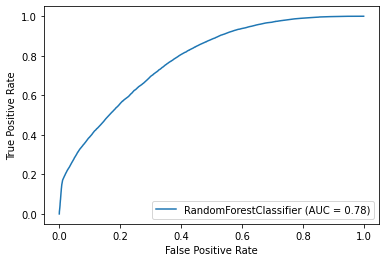

In [45]:
# ROC Curve:
sklearn.metrics.plot_roc_curve(clf_rf,x_rf_test,y_rf_test)
plt.show()

### Hypertune Parameters of Random Forest

In [47]:
param_grid = {'bootstrap': [True],'max_depth': [80, 90, 100, 110],'max_features': [10,20,30,40],'min_samples_leaf': [3, 4, 5],'min_samples_split': [8, 10, 12],'n_estimators': [100, 200, 500]}
from sklearn.model_selection import KFold
cv = KFold(n_splits=10,shuffle=True, random_state=111)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
from sklearn.model_selection import GridSearchCV
clf_rf_h = GridSearchCV(clf,param_grid=param_grid,cv=cv,n_jobs=-1,verbose=True)
clf_rf_h.fit(x_rf_train,y_rf_train)
y_rfh_hat = clf_rf_h.predict(x_rf_test)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(y_rf_test,y_rfh_hat))
print(confusion_matrix(y_rf_test,y_rfh_hat))
print(classification_report(y_rf_test,y_rfh_hat))

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 53.2min


KeyboardInterrupt: ignored

#### Had to interrupt session. Too Slow.

### Attempting Logistics Regression again post Imbalanced data treatment

In [ ]:
from sklearn.model_selection import GridSearchCV
clf_lr = GridSearchCV(clf,param_grid=param_grid,cv=cv,n_jobs=-1,verbose=True)
clf_lr.fit(x_rf_train,y_rf_train)
y_lr_hat = clf_lr.predict(x_rf_test)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(y_rf_test,y_lr_hat))
print(confusion_matrix(y_rf_test,y_lr_hat))
print(classification_report(y_rf_test,y_lr_hat))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 63.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 70.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.7109389310180606
[[17337 10018]
 [ 5763 21476]]
              precision    recall  f1-score   support

           1       0.75      0.63      0.69     27355
           2       0.68      0.79      0.73     27239

    accuracy                           0.71     54594
   macro avg       0.72      0.71      0.71     54594
weighted avg       0.72      0.71      0.71     54594

